In [1]:
from migdalcalc import migdalcalc
from migdalcalc.migdal import kinematics as kin
from migdalcalc.migdal import ionization as ion
import numpy as np
import scipy.integrate as integrate


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = False

In [2]:
#Change these Variables here
En = 180e3 #Incident nuetron energy in eV
Angle = 15 #Lab Frame Scattering angle in deg

In [3]:
#Define various useful constants and quantities

A = 40
N_per_g = (6.02e23/A)
barns_to_cm2 = 1e-24
flux = 100 #nuetrons/cm^2/second
days_to_seconds = 60*60*24 #days to seconds

R = 5 #cm
L = 1 #cm

V = (np.pi*R**2)*L
density = 1.395 #g / cm^3

mass = 1000 #grams

rate_prefactor = N_per_g*mass*barns_to_cm2*flux*days_to_seconds


In [12]:
#Cross Section of Elastic Scattering
Ar_migdal = migdalcalc.migdalcalc(target="Ar-40")

print("Argon Elastic Cross Section (barns): " + str(Ar_migdal.nuc.SIG(En)))

#Compute the Migdal Cross section
c_range = np.linspace(-1, 1)

mig_dE_spectrum = Ar_migdal.d2R_dc_dDeltaE(En)

mig_dE_arr = []

for c in c_range:
    dE_max = kin.DeltaE_Max(A, En, c)
    mig_dE = integrate.quad(lambda dE: mig_dE_spectrum(dE, c), 0, dE_max, limit=200, epsrel=1e-3)[0]
    
    mig_dE_arr.append(mig_dE)
    
    
mig_total_xsec = integrate.trapz(mig_dE_arr, c_range)
mig_rate = np.floor(mig_total_xsec*rate_prefactor)

print("Argon Migdal Cross Section (barns): " + str(mig_total_xsec))

print()

print("Ratio migdal/elastic: " + str(mig_total_xsec/Ar_migdal.nuc.SIG(En)))

print("Migdal Rate: " + "{r:e} evts/kg/day".format(r=mig_rate))

Argon Elastic Cross Section (barns): 4.71758
Argon Migdal Cross Section (barns): 0.02794221508259625

Ratio migdal/elastic: 0.0059229976137333655
Migdal Rate: 3.633382e+06 evts/kg/day


In [5]:
Ar_quench = lambda E: 0.25

c = np.cos(np.pi*Angle/180)

migdal_ionization_spectrum = Ar_migdal.dR_dEion(c, En, Ar_quench)

binned_migdal_spectrum = ion.noblegas_electron_spectrum_binned(migdal_ionization_spectrum, Ar_quench, 19.5, 0.05,
                                                              En, c, 40, flux=1, number_of_bins=20, fano=False)


print("Elastic Recoil Energy: " + str(kin.E_Recoil(0, c, 40, En)) + " eV")

Elastic Recoil Energy: 306.4096985304249 eV


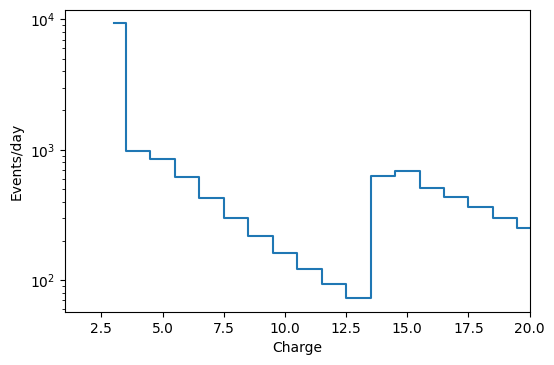

In [14]:
plt.step(binned_migdal_spectrum[0], np.multiply(rate_prefactor,binned_migdal_spectrum[1]),where='mid')
plt.yscale('log')
plt.xlim(1, 20)
plt.xlabel("Charge")
plt.ylabel('Events/day')
plt.show()
